## Loading Data, models

In [4]:
from proj.models import all_tokenizers
from proj.constants import DATA_DIR
import os
import pandas as pd

def split_col(df):
    train = df[df['phase'] == 'train']
    val = df[df['phase'] == 'dev']
    test = df[df['phase'] == 'test']
    return train, val, test
subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split_col(subset_df)

headline = lambda x: dfs[2].headline.iloc[x]
category = lambda x: dfs[2].category.iloc[x]

In [5]:
from bertviz import head_view, model_view
from proj.models import all_models, all_tokenizers, DistilBertForSequenceClassification
import torch

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=10, output_attentions=True)
model.load_state_dict(torch.load("./proj/model_weights/ablation/distilbert_balanced.pkl"))
tokenizer = all_tokenizers["distilBert"]()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [7]:
def attention_tokens(model, tokenizer, text):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    attention = model(input_ids)[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)
    return attention, tokens

def show_head_view(model, tokenizer, text, layer=5):
    attention, tokens = attention_tokens(model, tokenizer, text)
    head_view(attention, tokens, layer=layer)

In [10]:
show_head_view(model, tokenizer, headline(1000))

<IPython.core.display.Javascript object>

## Getting TopK Loss

In [ ]:
from proj.data.data import *
from proj.main import *
from proj.models import all_tokenizers
import os
import pandas as pd

def split_col(df):
    train = df[df['phase'] == 'train']
    val = df[df['phase'] == 'dev']
    test = df[df['phase'] == 'test']
    return train, val, test
subset_df = pd.read_csv(os.path.join(
    DATA_DIR, "train_test_split_dataset.csv"))
dfs = split_col(subset_df)
dls = []
bs = 256
model = "distilBert"
tokenizer = None
sampler = None

if model in all_tokenizers:
    tokenizer = all_tokenizers[model]()

for i, d in enumerate(dfs):
    ds = NewsDataset(d, tokenizer=tokenizer, stopwords=False)
    sampler = get_weighted_sampler(ds.labels()) if i == 0 else None
    dl = to_dataloader(ds, bs, sampler=sampler, drop_last=False)
    dls.append(dl)
model_name = "distilBert_noStopword"
hp = {**DEFAULT_HP, "model": model, "lr":2e-4, "epochs":5}
trainer = Trainer("stopwordCheck", model_name, dls, hp, bs)
trainer.load_weights("../ablation/distilbert_balanced.pkl")

In [2]:
topK = trainer.topKLoss(2, 100)

100%|██████████| 42/42 [00:20<00:00,  2.08it/s]


## Visualization code

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap

CMAP = get_cmap("Blues")

def get_attentions(outputs, layer=5, attention_head=0, avg=True):
  '''
  get the particular output for a particular layer and attention head
  layer -> 0 to 11
  attention_head -> 0 to 11
  '''
  if avg:
    #avg over all attention heads in a layer
    return outputs[layer].squeeze(0).mean(dim=0)

  #return values for a particular attention head inside a specific layer
  return outputs[layer].squeeze(0)[attention_head]

def plt_attentions(mat, labs, fig_size=(8,8), annot=False, cmap = CMAP, title=None):
  '''
  plot the NxN matrix passed as a heat map
  
  mat: square matrix to visualize
  labs: labels for xticks and yticks (the tokens in our case)
  '''
  fig, ax = plt.subplots(figsize=fig_size) 
  ax = sns.heatmap(mat.detach().numpy(), annot=annot, yticklabels=labs,xticklabels=labs, cmap=cmap)
  ax.xaxis.set_ticks_position('top')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  if title:
    ax.set_title(title)

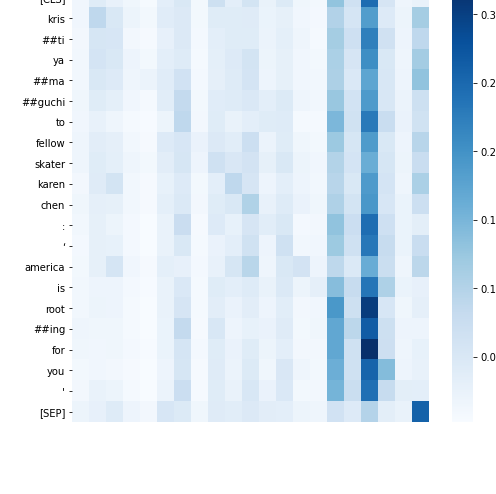

In [54]:
attention, tokens = attention_tokens(model, tokenizer, headline(400))
plt_attentions(get_attentions(attention), tokens)